# Daltix (Data Insights Consultant)

## Introduction

This Jupyter notebook has been crafted by Sven in preparation for the interview on Friday, the 24th. It serves as a comprehensive template for conducting detailed data analysis, specifically tailored for engaging with brands. The objective is to showcase how data insights can be leveraged to enhance brand strategies across various domains.

By utilizing this template, you can efficiently analyze and present data relevant to the four P's of marketing (Price, Product, Place, and Promotion). This approach is designed to provide actionable insights that can convincingly <b>demonstrate the value of the data services of Daltix to potential clients, ultimately driving them to invest in their offerings</b>.

### Notebook Outline

This notebook is structured to include the following key sections:

1. **Data Retrieval**: 
   - Importing necessary libraries
   - Connecting to the database
   - Querying, fetching and cleaning data

2. **Price Analysis (Analysis per product)**:
   - Price Evolution per Shop
   - Price Evolution per Location
   - Price Intervals
   - Competitor price comparison
   - Price sensitivity analysis

3. **Promotion Analysis**
   - Promo Prices
   - Comparative analysis of promo vs. regular pricing

4. **Product Analysis**:
   - Breakdown of product categories
   - Hierarchical categorization
   - Competitors analysis

8. **Place Analysis**:
   - Regional trends and insights

### Purpose and Usage

This notebook is intended to serve as a dynamic tool for data insights consultants at Daltix. By following the outlined sections, you can adapt the analysis to focus on specific brands or categories, providing a tailored approach to each client. The goal is to deliver compelling data-driven narratives that highlight opportunities for growth and optimization within the client's marketing strategy.

### Future Enhancements

As this template is a living document, feel free to modify, expand or request features for this notebook to suit the specific needs of the analysis.

---

Let's dive into the first section: **Data Retrieval**.


## Data Retrieval
### Importing necessary libraries

In [2]:
# Importing necessary libraries

# Data manipulation and analysis
import pandas as pd

# Database connection and querying
from sqlalchemy import create_engine

# Data visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from wordcloud import WordCloud

# Custom helper functions (assumed to be defined in helper.py)
from helper import load_data, create_summary

# Logging for debugging and tracking
import logging

# Handling dates and times
from datetime import datetime

# Pretty-printing tabular data
from tabulate import tabulate

# Numerical operations
import numpy as np

# Advanced color handling for plots
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap

# JSON handling
import json

# Configure logging
logging.basicConfig(filename='logbook.log', level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Display current date and time
print(f"Notebook executed on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


Notebook executed on: 2024-05-21 19:44:46


### Connecting to the database

In [3]:
# Setting the database connection details
user = "dx_candidate"
password = "_willYouBeADalton_?"
host = "ls-f9055767da2572a08e2e507348555c233a1a7e1b.cgfncspvwdvx.eu-central-1.rds.amazonaws.com"
dbname = "postgres"
port = "5432"

# Create the connection string
connection_string = f"postgresql://{user}:{password}@{host}:{port}/{dbname}"

# Create the database engine
engine = create_engine(connection_string)

### Querying, fetching and cleaning data

In [4]:
# Executing the data Extraction

## PLease choose for which brand (potential customer) the data should be extracted
brand = 'sultana'

## Leave blank if all categories of the brand can be analyzed
category = ''

## Define SQL queries to extract data
queries = {
    "weekly_prices_brand_fast": f"""
        SELECT 
            p2.name, p.week, p.location, p2.brand, p2.country, 
            p2.description, p2.categories, p.price, p.price_promo, p.shop
        FROM 
            weekly_prices AS p
        LEFT JOIN 
            products AS p2 ON p.daltix_id = p2.daltix_id
        WHERE 
            p2.brand = '{brand}'
            AND p2.categories LIKE '%{category}%' 
        ORDER BY 
            p.week, p.location
    """,
    
    "weekly_prices_brand": f"""
    WITH unique_nutritionals AS (
    SELECT
        daltix_id,
        nutritional_values_std,
        ROW_NUMBER() OVER (PARTITION BY daltix_id ORDER BY download_date DESC) AS rn
    FROM
        nutritionals
    )

    SELECT 
        p2.name,
        p.week,
        p.location,
        p2.brand,
        p2.country,
        p2.description,
        p2.categories,
        p.price,
        p.price_promo,
        p.shop,
        n.nutritional_values_std AS nutrition_info 
    FROM 
        weekly_prices AS p
    LEFT JOIN 
        products AS p2 ON p.daltix_id = p2.daltix_id
    LEFT JOIN
        (SELECT daltix_id, nutritional_values_std
        FROM unique_nutritionals
        WHERE rn = 1) AS n ON p.daltix_id = n.daltix_id
    WHERE 
        p2.brand = '{brand}'
        AND p2.categories LIKE '%{category}%' 
    ORDER BY 
        p.week, p.location;
        """
}

# Load data from the database
results = {}
for key, query in queries.items():
    logging.info(f"Starting query for {key}.")
    start_time = datetime.now()
    
    try:
        results[key] = load_data(engine, key, query)
        end_time = datetime.now()
        duration = end_time - start_time
        logging.info(f"Querying finished for {key}. Duration: {duration}.")
    except Exception as e:
        logging.error(f"Failed to execute query for {key}.", exc_info=True)
        results[key] = pd.DataFrame()

# Extract the result for 'weekly_prices_brand'
weekly_prices_brand = results.get('weekly_prices_brand', pd.DataFrame())

# Function to parse JSON string and extract up to 5 levels of categories
def extract_categories(json_string, max_levels=5):
    try:
        categories_list = json.loads(json_string)
        flattened_list = categories_list[-1]
        return (flattened_list + [None] * max_levels)[:max_levels]
    except (json.JSONDecodeError, IndexError, TypeError):
        return [None] * max_levels

# Apply the function to the 'categories' column and create separate columns for each level
max_levels = 5
categories_df = weekly_prices_brand['categories'].apply(lambda x: pd.Series(extract_categories(x, max_levels)))

# Rename the columns appropriately
categories_df.columns = [f'category_level_{i+1}' for i in range(max_levels)]

# Concatenate the original DataFrame with the new categories DataFrame
weekly_prices_brand = pd.concat([weekly_prices_brand, categories_df], axis=1)

# Drop the original 'categories' column
weekly_prices_brand.drop('categories', axis=1, inplace=True)

# Print the first few rows of the weekly_prices_brand DataFrame in a well-formatted way
print("Sample data:")
print(tabulate(weekly_prices_brand.head(), headers='keys', tablefmt='psql'))


Sample data:
+----+----------------------------------------------------+------------+-------------------------+---------+-----------+---------------------------------------------+---------+---------------+--------+-----------------------------------+------------------------+--------------------+--------------------+--------------------+--------------------+
|    | name                                               | week       | location                | brand   | country   | description                                 |   price |   price_promo | shop   | nutrition_info                    | category_level_1       | category_level_2   | category_level_3   | category_level_4   | category_level_5   |
|----+----------------------------------------------------+------------+-------------------------+---------+-----------+---------------------------------------------+---------+---------------+--------+-----------------------------------+------------------------+--------------------+----------

## Product
### Showing product names

In [5]:
# Get unique product names
unique_products = weekly_prices_brand['name'].unique()

# Print unique product names for verification
print("Unique product names:")
for product in unique_products:
    print(product)

Unique product names:
Koekjes | Fruit | Naturel
Sultana FruitBiscuit Bosvruchten 5 x 3 Stuks 218 g
Sultana FruitBiscuit Naturel 5 x 3 Stuks 218 g
Sultana FruitBiscuit Appel 5 x 3 Stuks 218 g


### Loading alternative products

In [6]:
product = 'Sultana FruitBiscuit Appel 5 x 3 Stuks 218 g'

product_data = weekly_prices_brand[weekly_prices_brand['name'] == product]

product_categories = product_data[['category_level_1', 'category_level_2', 'category_level_3', 'category_level_4', 'category_level_5']].drop_duplicates()
product_categories.fillna('', inplace=True)

queries = {
        "weekly_prices_brand_alternatives": f"""
        WITH unique_nutritionals AS (
        SELECT
                daltix_id,
                nutritional_values_std,
                ROW_NUMBER() OVER (PARTITION BY daltix_id ORDER BY download_date DESC) AS rn
        FROM
                nutritionals
        )

        SELECT 
        p2.name,
        p.week,
        p.location,
        p2.brand,
        p2.country,
        p2.description,
        p2.categories,
        p.price,
        p.price_promo,
        p.shop,
        n.nutritional_values_std AS nutrition_info 
        FROM 
        weekly_prices AS p
        LEFT JOIN 
        products AS p2 ON p.daltix_id = p2.daltix_id
        LEFT JOIN
        (SELECT daltix_id, nutritional_values_std
        FROM unique_nutritionals
        WHERE rn = 1) AS n ON p.daltix_id = n.daltix_id
        WHERE 
        p2.categories LIKE '%%{product_categories['category_level_1'].iloc[0]}%%'
        AND p2.categories LIKE '%%{product_categories['category_level_2'].iloc[0]}%%'
        AND p2.categories LIKE '%%{product_categories['category_level_3'].iloc[0]}%%'
        AND p2.categories LIKE '%%{product_categories['category_level_4'].iloc[0]}%%'
        AND p2.categories LIKE '%%{product_categories['category_level_5'].iloc[0]}%%'
        AND p2.brand != '{brand}'
        AND p2.name != '{product}'
        ORDER BY 
        p.week, p.location;
        """
        }

# Load data from the database
results = {}
for key, query in queries.items():
    print(f"Query started for {key}: {query}")
    start_time = datetime.now()
    results[key] = load_data(engine, key, query)
    end_time = datetime.now()
    duration = end_time - start_time
    print(f"Querying finished for {key}. Duration: {duration}.")
    print("\n")
    # Print the first few rows of the weekly_prices_brand DataFrame in a well-formatted way

    weekly_prices_brand_alternatives = results.get('weekly_prices_brand_alternatives', pd.DataFrame())
    print("Sample data:")
    print(tabulate(weekly_prices_brand_alternatives.head(), headers='keys', tablefmt='psql'))

Query started for weekly_prices_brand_alternatives_fast: SELECT p2.name, p.week, p.location, p2.brand, p2.country, p2.description, p2.categories, p.price, p.price_promo, p.shop
                FROM weekly_prices AS p
                LEFT JOIN products AS p2 ON p.daltix_id = p2.daltix_id
                WHERE p2.categories LIKE '%%Kruidenierswaren%%'
                and p2.categories LIKE '%%Koeken & taarten%%'
                and p2.categories LIKE '%%Koeken%%'
                and p2.categories LIKE '%%Ontbijtkoeken%%'
                and p2.categories LIKE '%%%%'
                and p2.brand != 'sultana'
                and p2.name != 'Sultana FruitBiscuit Appel 5 x 3 Stuks 218 g'
                order by p.week, p.location


Querying finished for weekly_prices_brand_alternatives_fast. Duration: 0:00:01.443364.


Sample data:

Query started for weekly_prices_brand_alternatives: 
        WITH unique_nutritionals AS (
        SELECT
                daltix_id,
                nutritional_values_std,
                ROW_NUMBER() OVER (PARTITION BY daltix_id ORDER BY download_date DESC) AS rn
        FROM
                nutritionals
        )

        SELECT 
        p2.name,
        p.week,
        p.location,
        p2.brand,
        p2.country,
        p2.description,
        p2.categories,
        p.price,
        p.price_promo,
        p.shop,
        n.nutritional_values_std AS nutrition_info 
        FROM 
        weekly_prices AS p
        LEFT JOIN 
        products AS p2 ON p.daltix_id = p2.daltix_id
        LEFT JOIN
        (SELECT daltix_id, nutritional_values_std
        FROM unique_nutritionals
        WHERE rn = 1) AS n ON p.daltix_id = n.daltix_id
        WHERE 
        p2.categories LIKE '%%K

### Summing up alternative products per supplier

In [20]:
print(f"Alternative products for: {product}")
print("\n")
print(f"The first category: {product_categories['category_level_1'].iloc[0]}")
print(f"The second category: {product_categories['category_level_2'].iloc[0]}")
print(f"The third category: {product_categories['category_level_3'].iloc[0]}")
print(f"The fourth category: {product_categories['category_level_4'].iloc[0]}")
print(f"The fifth category: {product_categories['category_level_5'].iloc[0]}")
print("\n")
# Group by brand and count the unique product names
brand_product_counts = weekly_prices_brand_alternatives.groupby('brand')['name'].agg(['nunique', 'unique'])

# Print the count per brand and the names of the unique products
print("Number of alternative products offered by each brand:")
print("\n")

for brand_name, (count, unique_names) in brand_product_counts.iterrows():
    print(f"{brand_name}: {count}")
    print("Unique Product Names:")
    print(",\n ".join(unique_names))
    print()

Alternative products for: Sultana FruitBiscuit Appel 5 x 3 Stuks 218 g


The first category: Kruidenierswaren
The second category: Koeken & taarten
The third category: Koeken
The fourth category: Ontbijtkoeken
The fifth category: 


Number of alternative products offered by each brand:


carrefour: 1
Unique Product Names:
Carrefour Petit Beurre 2 x 12 Stuks 200 g

céréal: 6
Unique Product Names:
Céréal Zonder Suikers Zandkoekjes Choc-Orange 3 x 4 st 132 g,
 Céréal Glutenfree & Lactosefree Zandkoekjes Framboos 4 x 5 Stuks 120 g,
 Céréal Minder Suikers Duette Cacao 9 Koekjes 150 g,
 Céréal Minder Suikers Choco Delight 12 Koekjes 126 g,
 Céréal Zonder Suikers Zandkoekjes Natuur 3 x 4 Koekjes 132 g,
 Céréal Zonder Suikers Koekjes Sesam met Vanillesmaak 3 x 4 st 132 g

gerblé: 1
Unique Product Names:
Gerblé Sans Gluten Crousti'pause Cacao Noisettes 5 x 2 Stuks

lu: 7
Unique Product Names:
LU Grany Moelleux Chocolade 192 g,
 LU BelVita Ontbijt Soft Baked Multi Granen 250 g,
 LU Grany Biscuit

In [ ]:
### Showing wordclouds for product names and descriptions.

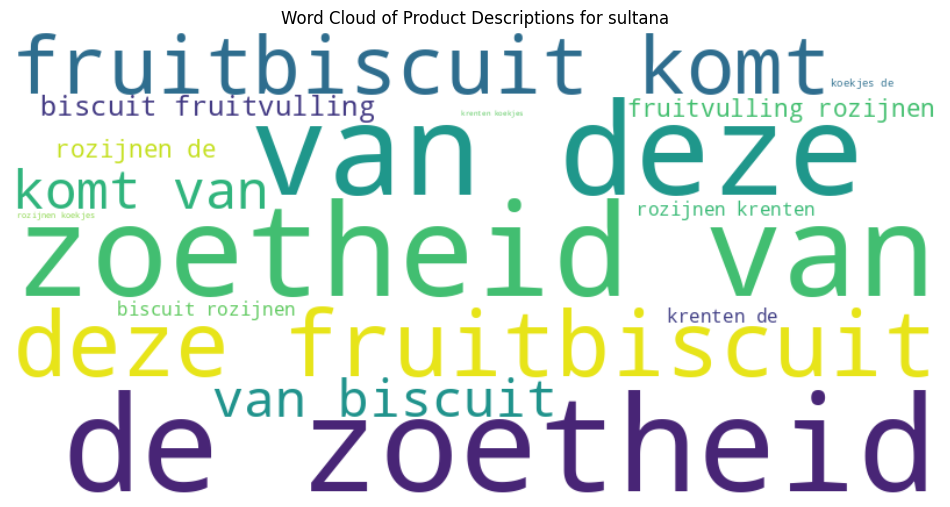

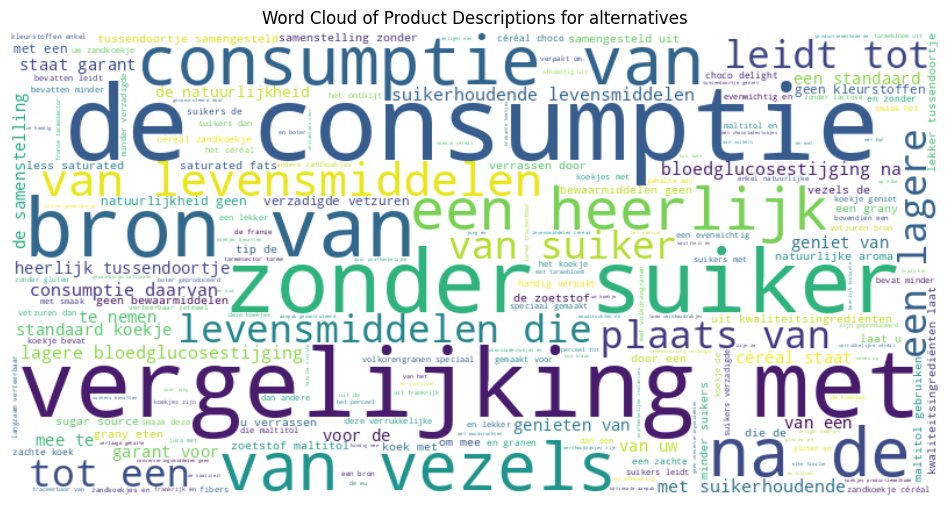

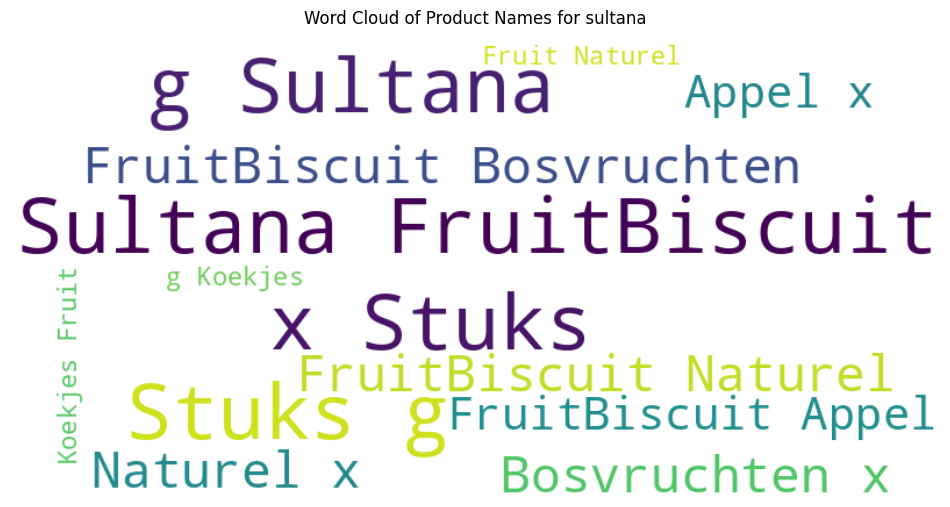

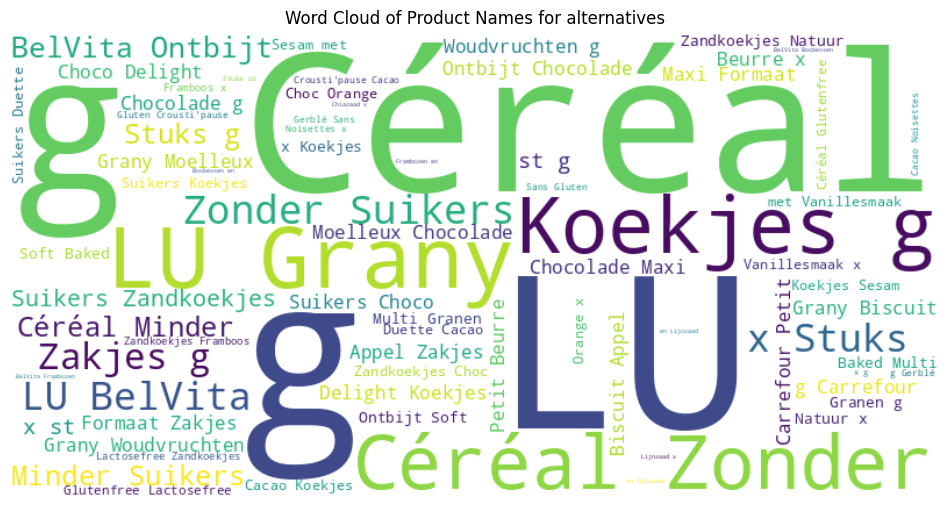

In [21]:
def generate_wordcloud(data, column, title):
    all_text = ' '.join(data[column].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generate word cloud for descriptions
generate_wordcloud(weekly_prices_brand, 'description', f'Word Cloud of Product Descriptions for {brand}')
generate_wordcloud(weekly_prices_brand_alternatives, 'description', f'Word Cloud of Product Descriptions for alternatives')

# Generate word cloud for names
generate_wordcloud(weekly_prices_brand, 'name', f'Word Cloud of Product Names for {brand}')
generate_wordcloud(weekly_prices_brand_alternatives, 'name', f'Word Cloud of Product Names for alternatives')

### Analyzing the nutritions of the product (& alternatives)

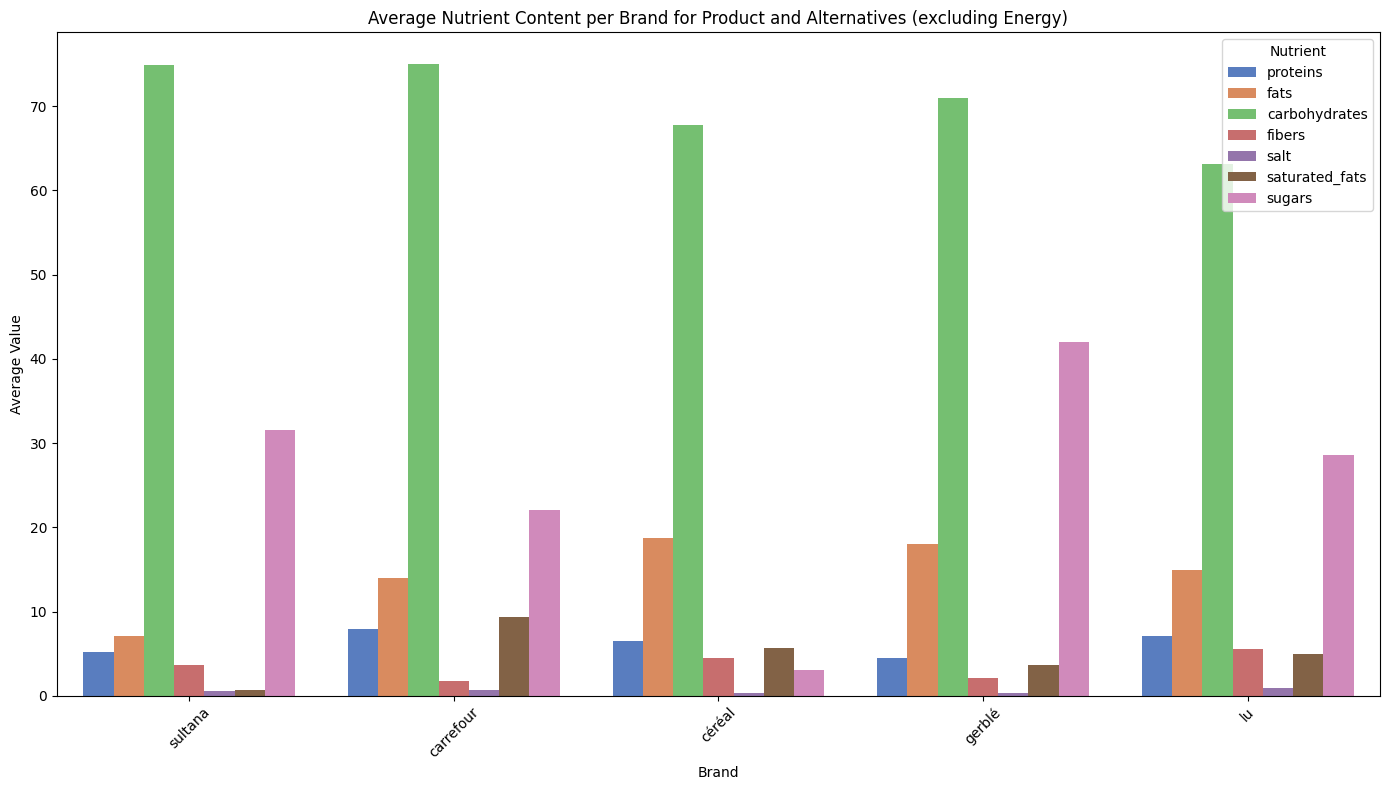

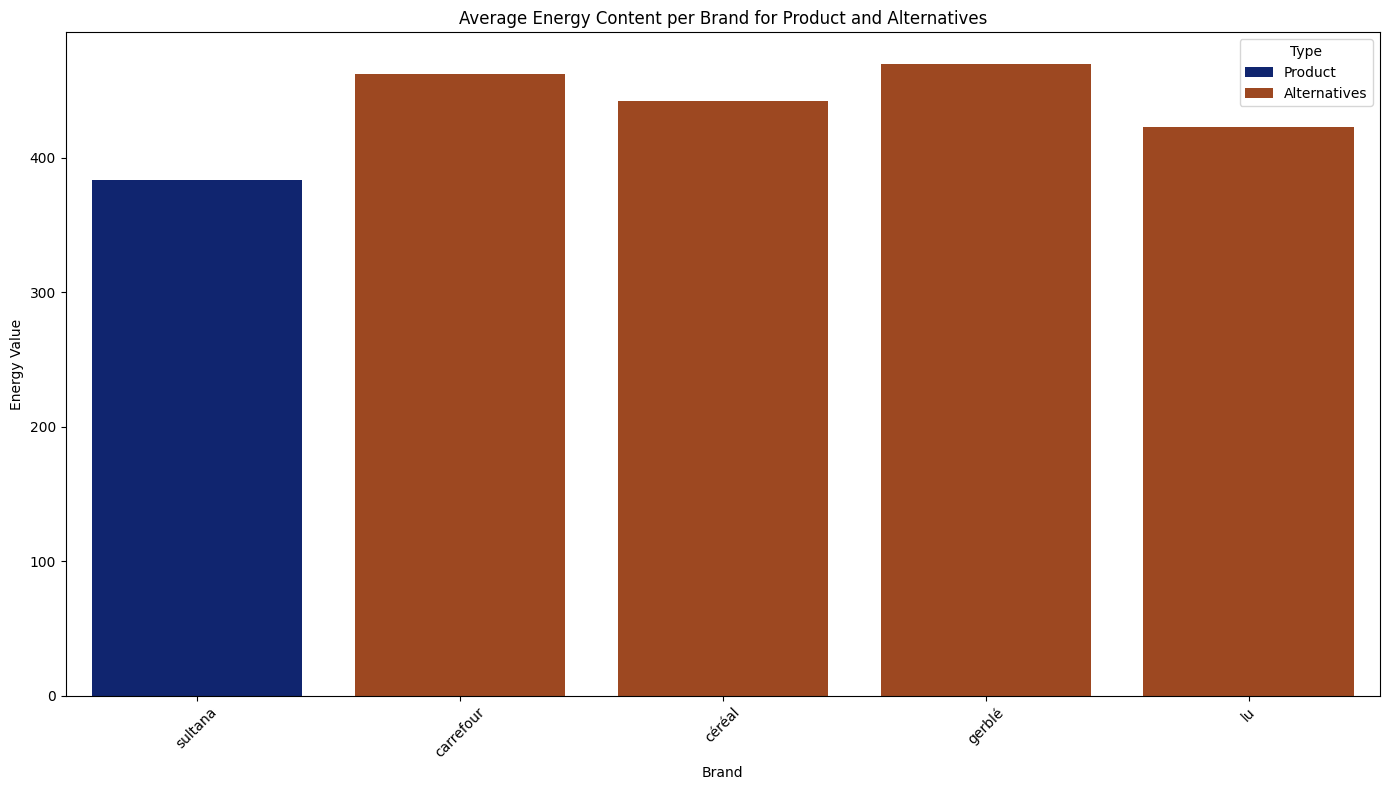

In [27]:
# Function to extract specified nutrient value from nutrition_info
def extract_nutrient(nutrition_info, nutrient_name):
    try:
        nutrients = json.loads(nutrition_info)["nutrients"]
        return nutrients[nutrient_name]["value"]
    except (json.JSONDecodeError, KeyError, TypeError):
        return None

# List of nutrients to extract
# List of nutrients to extract
nutrients_to_extract = ['proteins', 'fats', 'kilocalories', 'carbohydrates', 'fibers', 'salt', 'saturated_fats', 'sugars']
energy_nutrient = 'kilocalories'

# Apply the function to the 'nutrition_info' column and create new columns for each nutrient
for nutrient in nutrients_to_extract:
    weekly_prices_brand[nutrient] = weekly_prices_brand['nutrition_info'].apply(lambda x: extract_nutrient(x, nutrient))
    weekly_prices_brand_alternatives[nutrient] = weekly_prices_brand_alternatives['nutrition_info'].apply(lambda x: extract_nutrient(x, nutrient))

# Extract energy values
weekly_prices_brand[energy_nutrient] = weekly_prices_brand['nutrition_info'].apply(lambda x: extract_nutrient(x, energy_nutrient))
weekly_prices_brand_alternatives[energy_nutrient] = weekly_prices_brand_alternatives['nutrition_info'].apply(lambda x: extract_nutrient(x, energy_nutrient))

# Filter data for the specified product
filtered_data_product = weekly_prices_brand[weekly_prices_brand['name'] == product]

# Group by brand and calculate average nutrient values
average_nutrients_product = filtered_data_product.groupby('brand')[nutrients_to_extract + [energy_nutrient]].mean().reset_index()
average_nutrients_alternatives = weekly_prices_brand_alternatives.groupby('brand')[nutrients_to_extract + [energy_nutrient]].mean().reset_index()

# Add a column to differentiate between product and alternatives
average_nutrients_product['Type'] = 'Product'
average_nutrients_alternatives['Type'] = 'Alternatives'

# Concatenate the DataFrames
combined_data = pd.concat([average_nutrients_product, average_nutrients_alternatives], ignore_index=True)

# Separate energy data
energy_data = combined_data[['brand', 'Type', energy_nutrient]]
nutrients_data = combined_data.drop(columns=[energy_nutrient])

# Melt the DataFrames
melted_nutrients = nutrients_data.melt(id_vars=['brand', 'Type'], var_name='Nutrient', value_name='Value')
melted_energy = energy_data.melt(id_vars=['brand', 'Type'], var_name='Nutrient', value_name='Value')

# Plot the nutrient data
plt.figure(figsize=(14, 8))
sns.barplot(x='brand', y='Value', hue='Nutrient', data=melted_nutrients, palette='muted')
plt.xlabel('Brand')
plt.ylabel('Average Value')
plt.title('Average Nutrient Content per Brand for Product and Alternatives (excluding Energy)')
plt.xticks(rotation=45)
plt.legend(title='Nutrient')
plt.tight_layout()
plt.show()

# Plot the energy data
plt.figure(figsize=(14, 8))
sns.barplot(x='brand', y='Value', hue='Type', data=melted_energy, palette='dark')
plt.xlabel('Brand')
plt.ylabel('Energy Value')
plt.title('Average Energy Content per Brand for Product and Alternatives')
plt.xticks(rotation=45)
plt.legend(title='Type')
plt.tight_layout()
plt.show()


## Prices
### Showing the price evolution per product (graph) and shop (line).

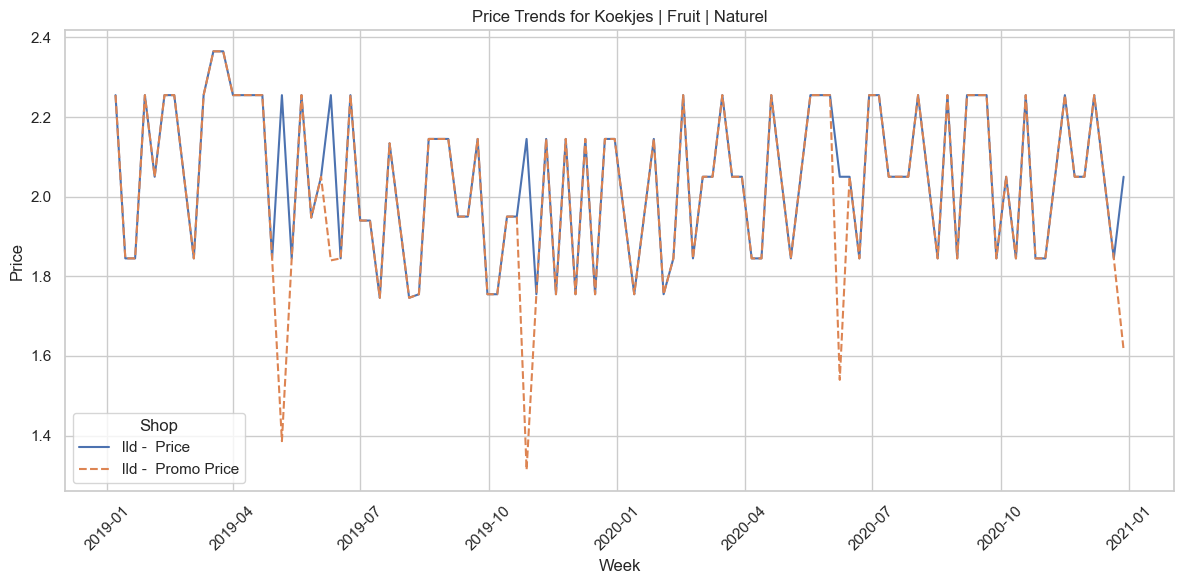

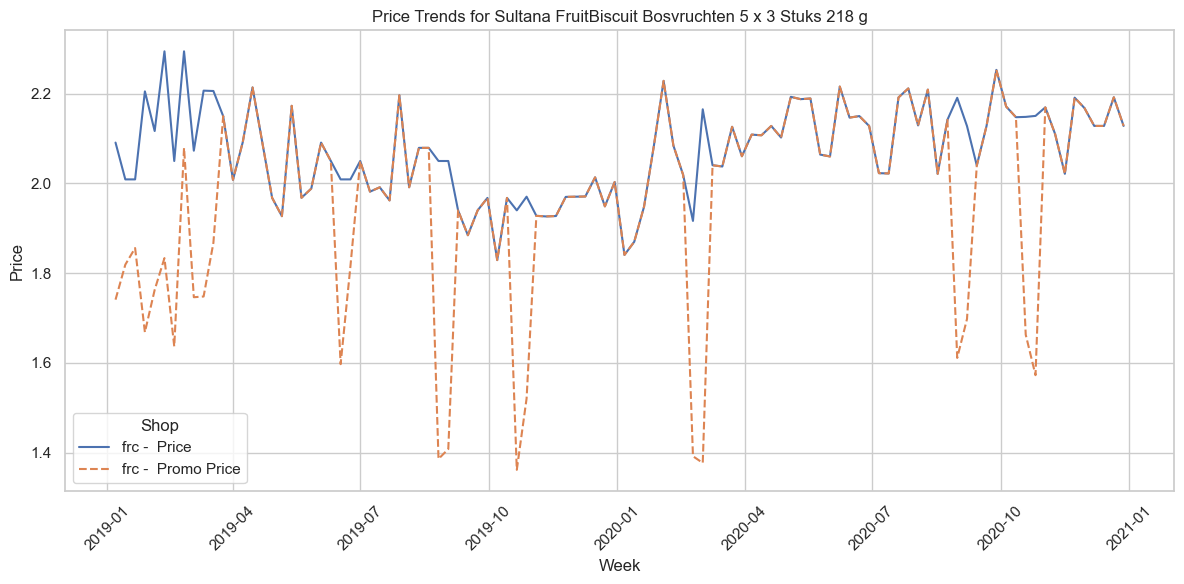

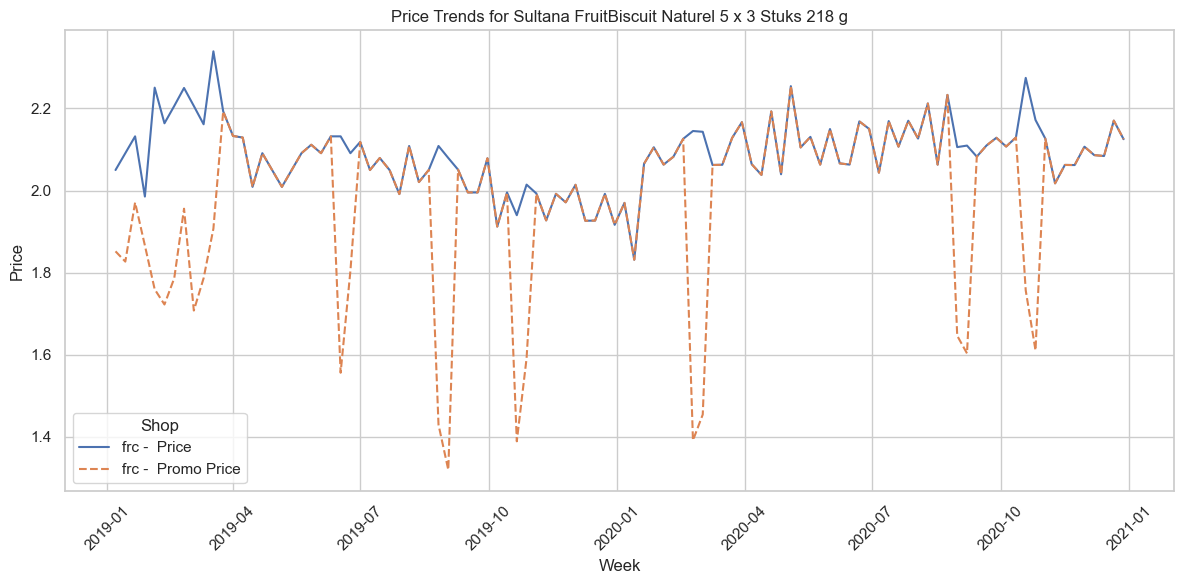

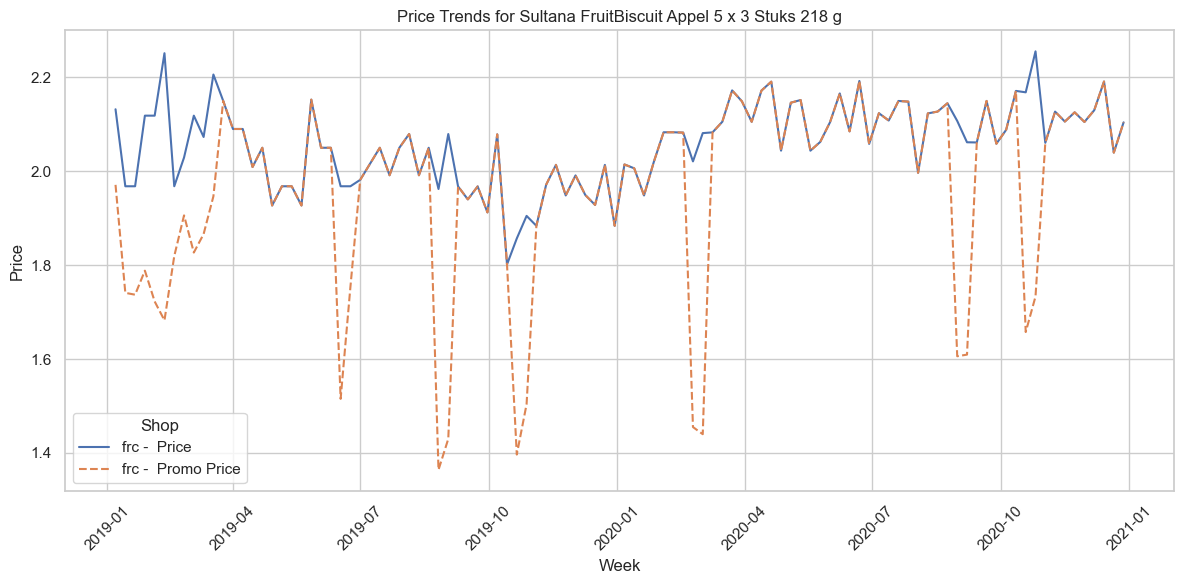

In [ ]:
# Set plot style
sns.set(style="whitegrid")

# Iterate over each unique product
for product in unique_products:
    product_data = weekly_prices_brand[weekly_prices_brand['name'] == product]

    plt.figure(figsize=(12, 6))
    plt.title(f"Price Trends for {product}")
    plt.xlabel('Week')
    plt.ylabel('Price')

    # Plot data for each shop
    for shop in product_data['shop'].unique():
        shop_data = product_data[product_data['shop'] == shop]
        sns.lineplot(x='week', y='price', data=shop_data, label=f"{shop} -  Price", errorbar=None)
        sns.lineplot(x='week', y='price_promo', data=shop_data, label=f"{shop} -  Promo Price", errorbar=None, linestyle='dashed')

    plt.legend(title='Shop')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Showing the price evolution per product (graph) and location (line)

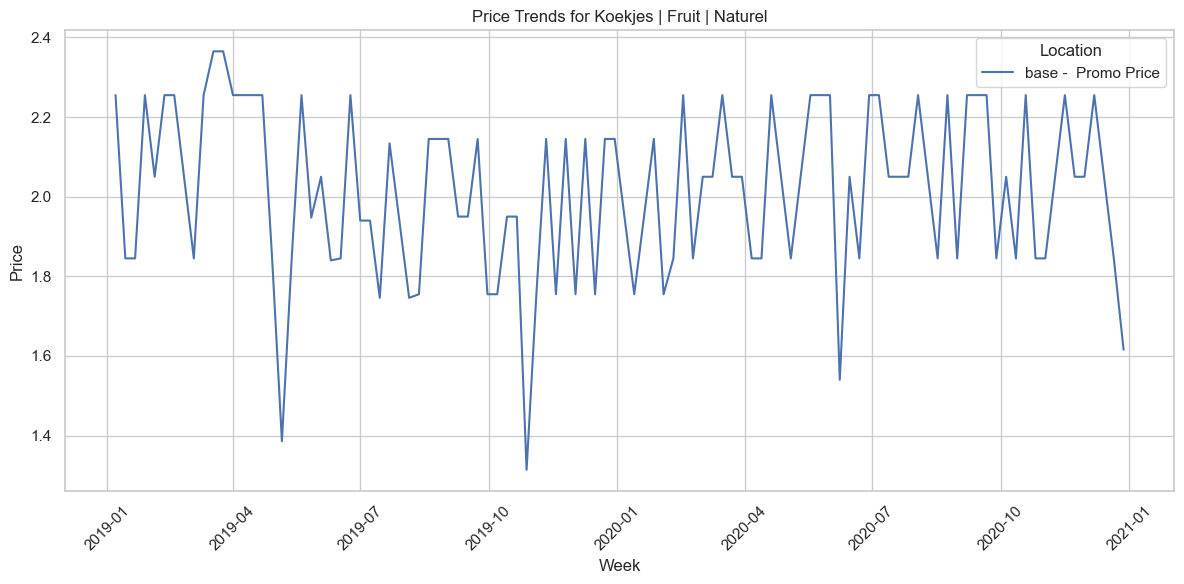

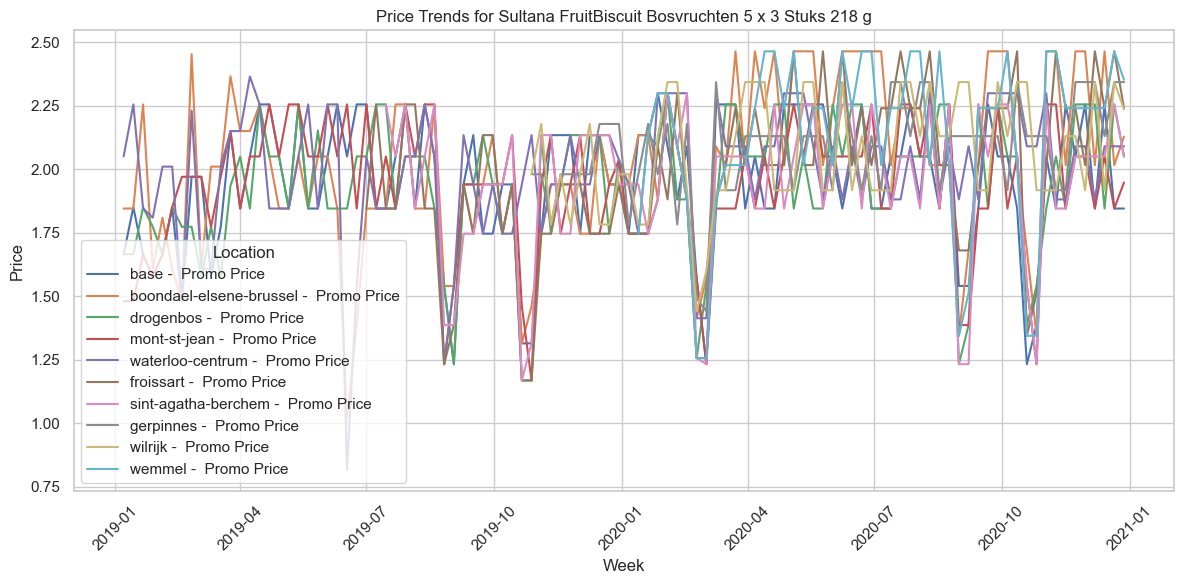

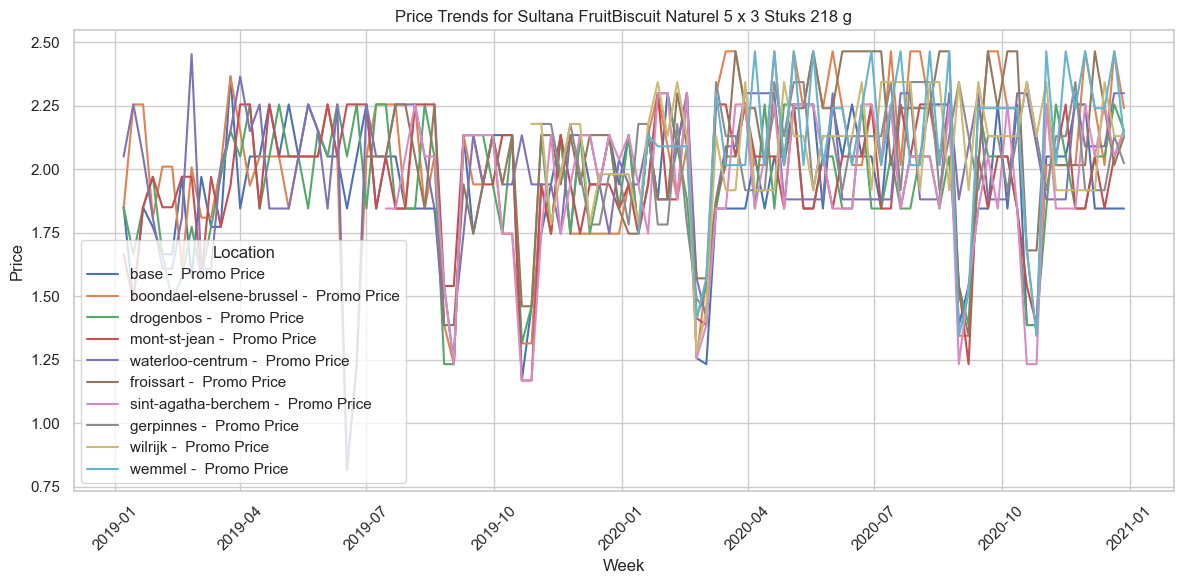

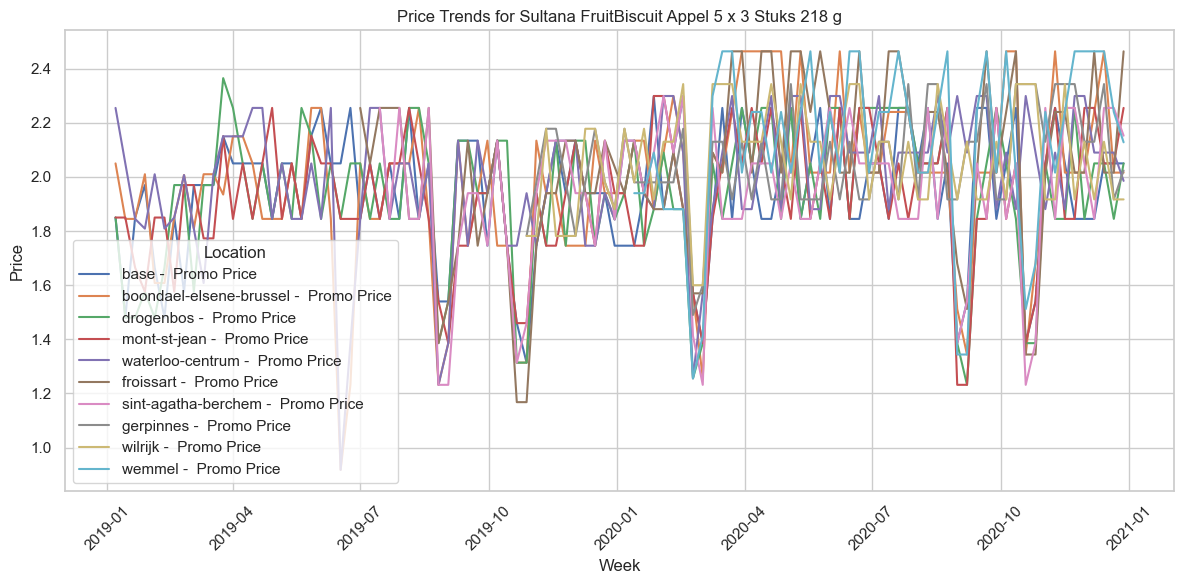

In [ ]:
# Set plot style
sns.set(style="whitegrid")

# Iterate over each unique product
for product in unique_products:
    product_data = weekly_prices_brand[weekly_prices_brand['name'] == product]

    plt.figure(figsize=(12, 6))
    plt.title(f"Price Trends for {product}")
    plt.xlabel('Week')
    plt.ylabel('Price')

    # Plot data for each shop
    for location in product_data['location'].unique():
        location_data = product_data[product_data['location'] == location]
        # sns.lineplot(x='week', y='price', data=location_data, label=f"{location} -  Price", errorbar=None)
        sns.lineplot(x='week', y='price_promo', data=location_data, label=f"{location} -  Promo Price", errorbar=None)

    plt.legend(title='Location')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Number of weeks in a certain price interval

In [ ]:
# Function to calculate price intervals and count weeks in each interval
def get_price_interval_counts(df):
    # Make a copy of the DataFrame to avoid SettingWithCopyWarning
    df = df.copy()

    price_intervals = np.percentile(df['price'], [0, 25, 50, 75, 100])
    interval_labels = [
        f"{price_intervals[i]:.2f}-{price_intervals[i+1]:.2f}" for i in range(len(price_intervals) - 1)
    ]
    
    df['price_interval'] = pd.cut(df['price'], bins=price_intervals, labels=interval_labels, include_lowest=True)
    
    return df.groupby(['location', 'price_interval'], observed=True).size().unstack(fill_value=0)

def rgba_to_hex(color):
    return '#{:02x}{:02x}{:02x}'.format(int(color[0]*255), int(color[1]*255), int(color[2]*255))

# Normalize each row to [0, 1] range for coloring
def row_style(row):
    normalized = Normalize(vmin=row.min(), vmax=row.max())(row)
    cmap = matplotlib.colormaps['Wistia']
    return [f'background-color: {rgba_to_hex(cmap(norm))}; color: black' for norm in normalized]

# Iterate over each unique product
for product in unique_products:
    product_data = weekly_prices_brand[weekly_prices_brand['name'] == product]
    
    # Calculate the interval counts for the product
    interval_counts = get_price_interval_counts(product_data)
    
    # Apply the style
    styled_df = interval_counts.style.apply(row_style, axis=1).set_caption(f"Price Intervals for {product}")

    # Display the styled DataFrame
    display(styled_df)

### Prices comparing to alternatives per location

### Prices comparing to alternatives (average of all locations)

## Location

## Promotion

### Showing the distribution of the discounts. 

In [52]:
# Define custom categories for promotional price differences
promo_categories = ['No Promo', '1% to 20% Discount', '20% to 40% Discount', 'Above 40% Discount']

# Create a column for promo category
promo_diff = (weekly_prices_brand['price'] - weekly_prices_brand['price_promo']) / weekly_prices_brand['price'] * 100
weekly_prices_brand['promo_category'] = pd.cut(promo_diff, bins=[-np.inf, 0, 20, 40, np.inf], labels=promo_categories)

# Group by product and location to calculate the total weeks for each combination
total_weeks = weekly_prices_brand.groupby(['name', 'location'])['promo_category'].value_counts(normalize=True).unstack(fill_value=0) * 100

# Iterate over each unique product
for product in weekly_prices_brand['name'].unique():
    print(f"Promotional Price Distribution for {product}")
    # Filter data for the current product
    product_data = weekly_prices_brand[weekly_prices_brand['name'] == product]
    
    # Group by location and promo category to count the number of weeks in each category
    promo_counts = product_data.groupby(['location', 'promo_category'], observed=False).size().unstack(fill_value=0)
    
    # Calculate the percentage of total weeks for each category
    promo_percentages = round(promo_counts.div(promo_counts.sum(axis=1), axis=0) * 100,0)
    
    # Rename columns for better clarity
    promo_percentages.columns = [f'{category} Percentage' for category in promo_percentages.columns]
    
    # Display the percentages table for the current product
    display(promo_percentages)


Promotional Price Distribution for Koekjes | Fruit | Naturel


No Promo Percentage  1% to 20% Discount Percentage  \
location                                                       
base                     95.0                            1.0   

          20% to 40% Discount Percentage  Above 40% Discount Percentage  
location                                                                 
base                                 4.0                            0.0

Promotional Price Distribution for Sultana FruitBiscuit Bosvruchten 5 x 3 Stuks 218 g


No Promo Percentage  1% to 20% Discount Percentage  \
location                                                                      
base                                    80.0                            7.0   
boondael-elsene-brussel                 82.0                            7.0   
drogenbos                               81.0                            6.0   
froissart                               88.0                            0.0   
gerpinnes                               97.0                            2.0   
mont-st-jean                            80.0                            8.0   
sint-agatha-berchem                     87.0                            0.0   
waterloo-centrum                        89.0                            4.0   
wemmel                                  88.0                            0.0   
wilrijk                                 97.0                            0.0   

                         20% to 40% Discount Percentage  \
location                                                  
base                                               11.0   
boondael-elsene-brussel                             7.0   
drogenbos                                          11.0   
froissart                                           7.0   
gerpinnes                                           2.0   
mont-st-jean                                        9.0   
sint-agatha-berchem                                11.0   
waterloo-centrum                                    7.0   
wemmel                                             10.0   
wilrijk                                             3.0   

                         Above 40% Discount Percentage  
location                                                
base                                               1.0  
boondael-elsene-brussel                            3.0  
drogenbos                                          2.0  
froissart                                          5.0  
gerpinnes                                          0.0  
mont-st-jean                                       2.0  
sint-agatha-berchem                                1.0  
waterloo-centrum                                   1.0  
wemmel                                             2.0  
wilrijk                                            0.0

Promotional Price Distribution for Sultana FruitBiscuit Naturel 5 x 3 Stuks 218 g


No Promo Percentage  1% to 20% Discount Percentage  \
location                                                                      
base                                    80.0                            7.0   
boondael-elsene-brussel                 82.0                            6.0   
drogenbos                               80.0                            7.0   
froissart                               88.0                            4.0   
gerpinnes                               97.0                            0.0   
mont-st-jean                            81.0                            7.0   
sint-agatha-berchem                     87.0                            1.0   
waterloo-centrum                        88.0                            3.0   
wemmel                                  88.0                            0.0   
wilrijk                                 97.0                            0.0   

                         20% to 40% Discount Percentage  \
location                                                  
base                                               13.0   
boondael-elsene-brussel                             7.0   
drogenbos                                          12.0   
froissart                                           7.0   
gerpinnes                                           3.0   
mont-st-jean                                       10.0   
sint-agatha-berchem                                 9.0   
waterloo-centrum                                    8.0   
wemmel                                             10.0   
wilrijk                                             2.0   

                         Above 40% Discount Percentage  
location                                                
base                                               0.0  
boondael-elsene-brussel                            5.0  
drogenbos                                          0.0  
froissart                                          1.0  
gerpinnes                                          0.0  
mont-st-jean                                       1.0  
sint-agatha-berchem                                3.0  
waterloo-centrum                                   1.0  
wemmel                                             2.0  
wilrijk                                            2.0

Promotional Price Distribution for Sultana FruitBiscuit Appel 5 x 3 Stuks 218 g


No Promo Percentage  1% to 20% Discount Percentage  \
location                                                                      
base                                    82.0                            7.0   
boondael-elsene-brussel                 84.0                            3.0   
drogenbos                               80.0                            6.0   
froissart                               88.0                            1.0   
gerpinnes                               97.0                            2.0   
mont-st-jean                            80.0                            9.0   
sint-agatha-berchem                     87.0                            1.0   
waterloo-centrum                        90.0                            3.0   
wemmel                                  88.0                            0.0   
wilrijk                                 97.0                            3.0   

                         20% to 40% Discount Percentage  \
location                                                  
base                                               11.0   
boondael-elsene-brussel                            11.0   
drogenbos                                          13.0   
froissart                                          11.0   
gerpinnes                                           2.0   
mont-st-jean                                        9.0   
sint-agatha-berchem                                10.0   
waterloo-centrum                                    7.0   
wemmel                                             12.0   
wilrijk                                             0.0   

                         Above 40% Discount Percentage  
location                                                
base                                               0.0  
boondael-elsene-brussel                            2.0  
drogenbos                                          1.0  
froissart                                          0.0  
gerpinnes                                          0.0  
mont-st-jean                                       1.0  
sint-agatha-berchem                                1.0  
waterloo-centrum                                   1.0  
wemmel                                             0.0  
wilrijk                                            0.0

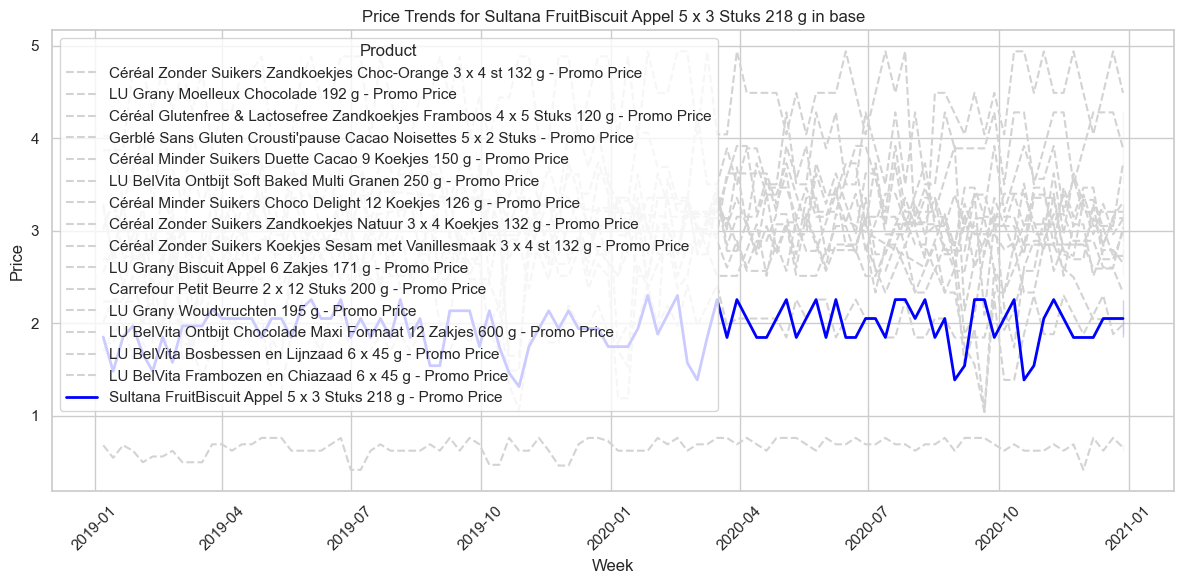

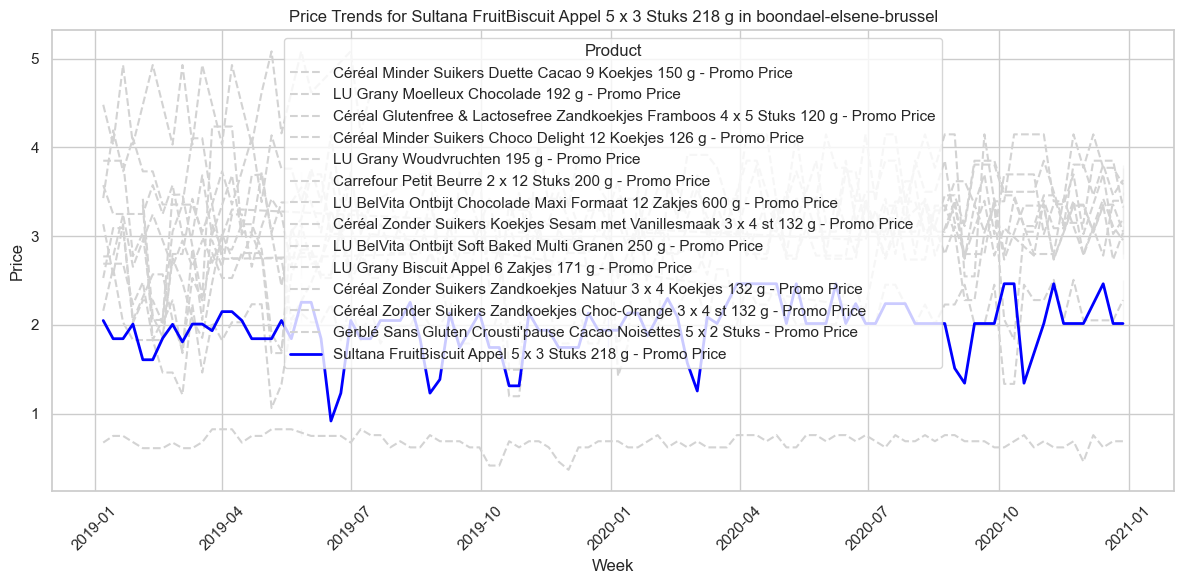

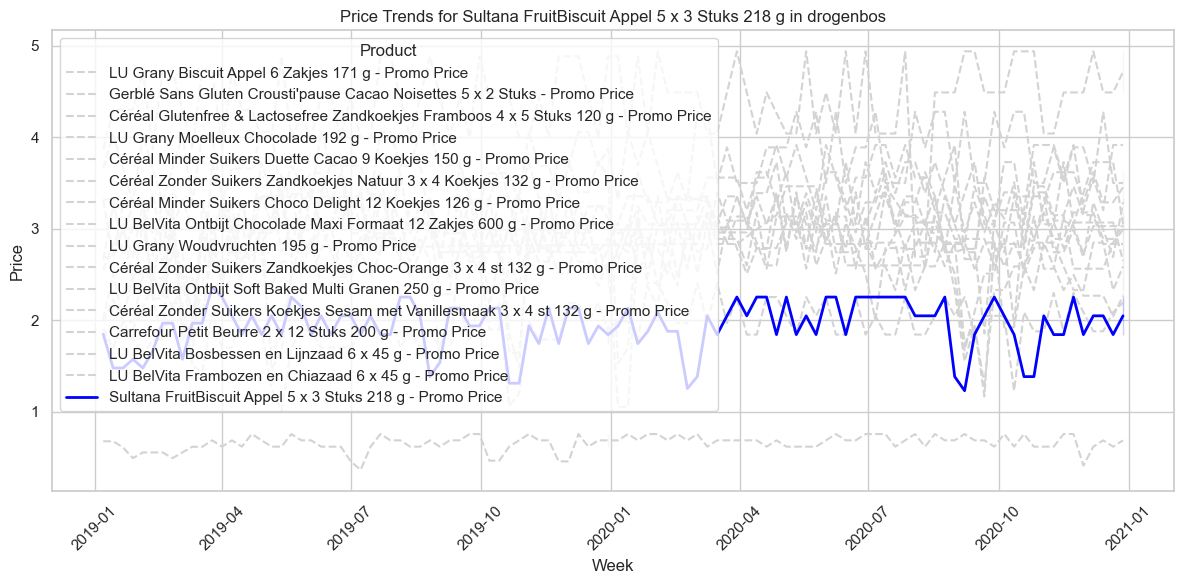

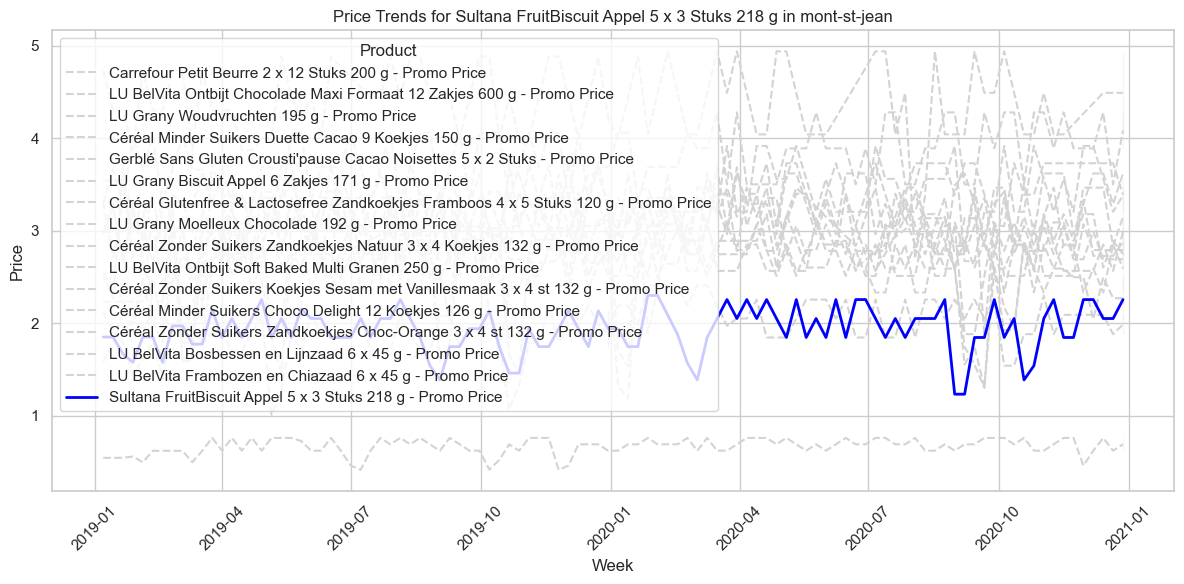

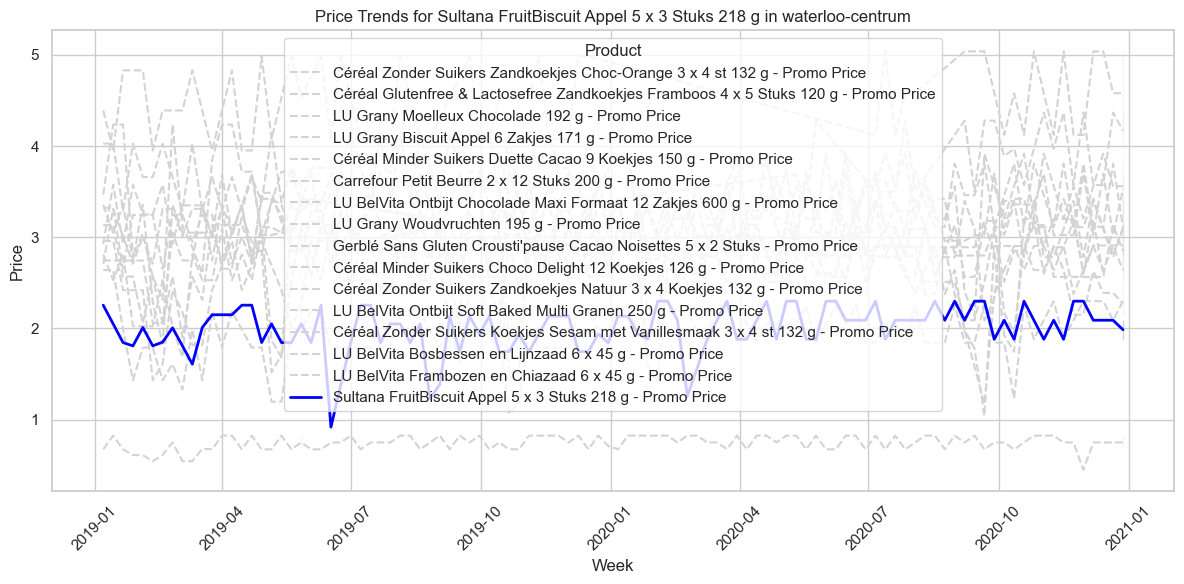

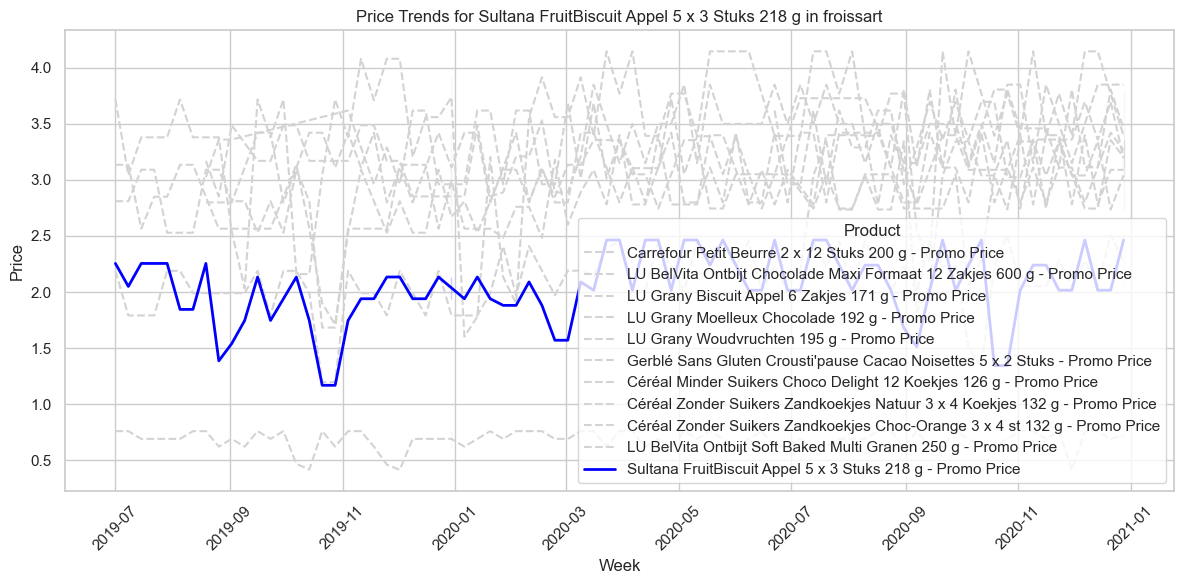

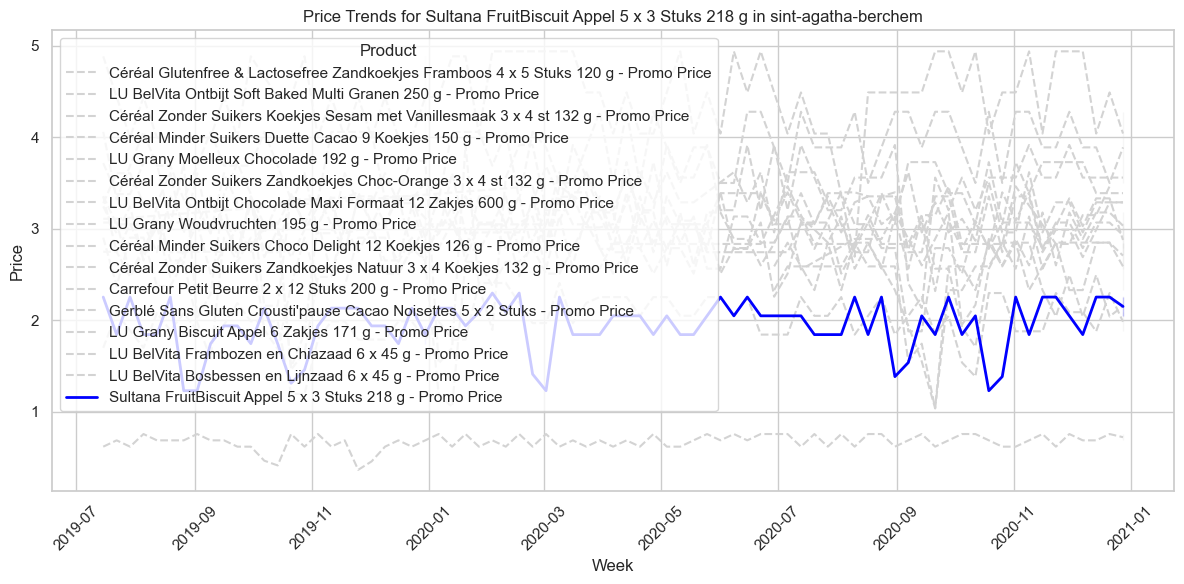

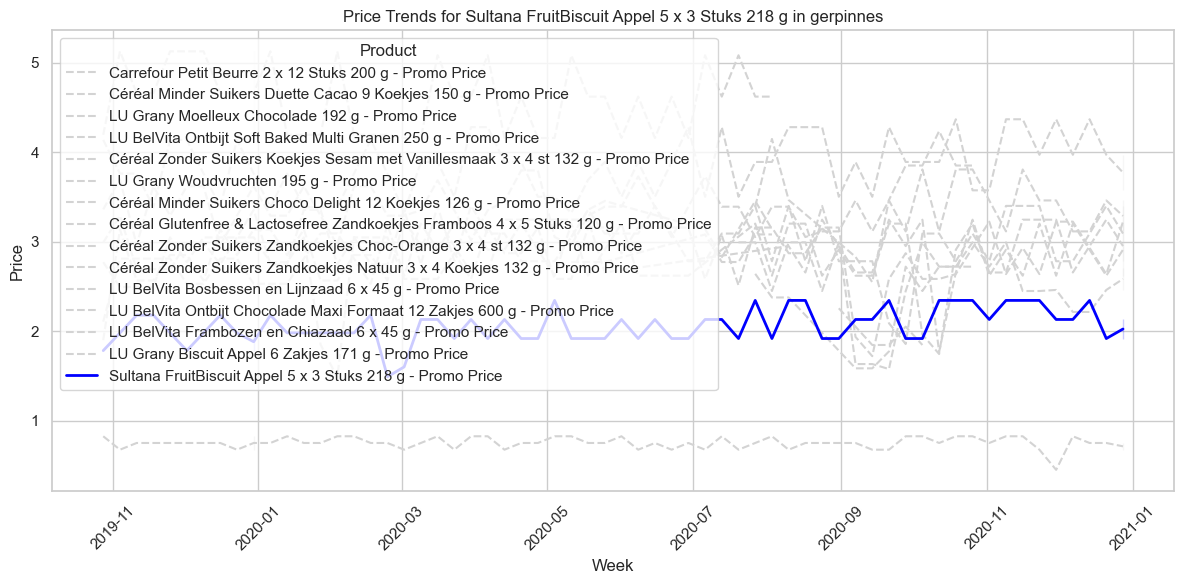

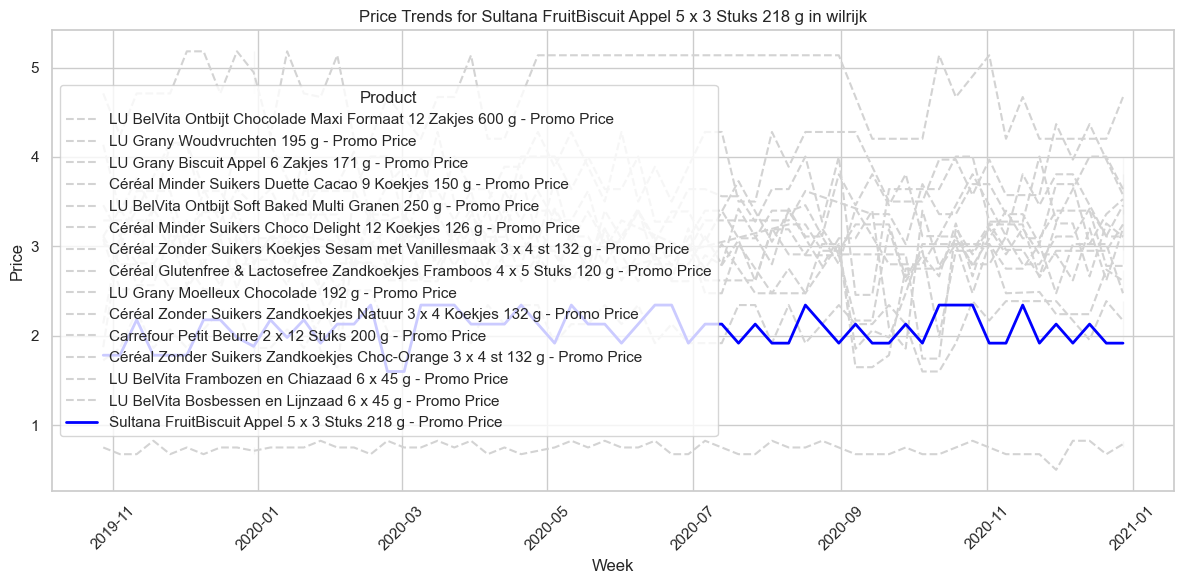

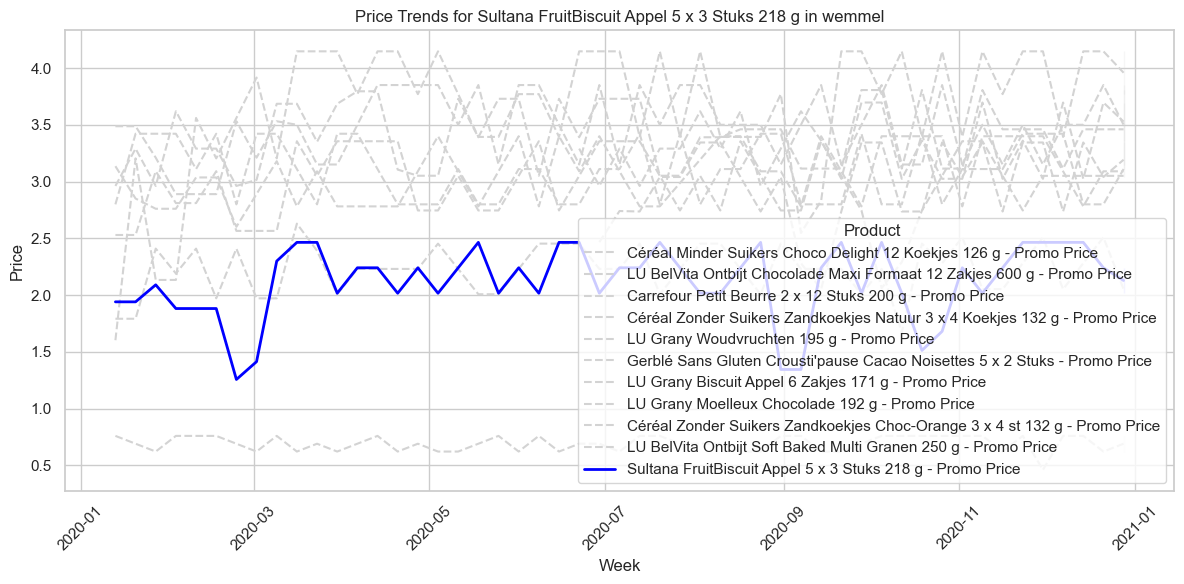

In [53]:
# Get unique locations
unique_locations = weekly_prices_brand_alternatives['location'].unique()

# Set plot style
sns.set(style="whitegrid")

# Iterate over each unique location
for location in unique_locations:
    # Filter data for the current location in weekly_prices_brand_alternatives
    location_data_alternatives = weekly_prices_brand_alternatives[weekly_prices_brand_alternatives['location'] == location]
    
    # Filter data for the specified product in weekly_prices_brand
    location_data_product = weekly_prices_brand[(weekly_prices_brand['location'] == location) & (weekly_prices_brand['name'] == product)]

    # Plot setup
    plt.figure(figsize=(12, 6))
    plt.title(f"Price Trends for {product} in {location}")
    plt.xlabel('Week')
    plt.ylabel('Price')

    # Plot data for each product in the current location from weekly_prices_brand_alternatives
    for name in location_data_alternatives['name'].unique():
        product_data = location_data_alternatives[location_data_alternatives['name'] == name]
        sns.lineplot(x='week', y='price_promo', data=product_data, label=f"{name} - Promo Price", color='lightgrey', linestyle='--')

    # Plot data for the specified product from weekly_prices_brand
    sns.lineplot(x='week', y='price_promo', data=location_data_product, label=f"{product} - Promo Price", color='blue', linestyle='-', linewidth=2)

    # Show legend and adjust layout
    plt.legend(title='Product')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

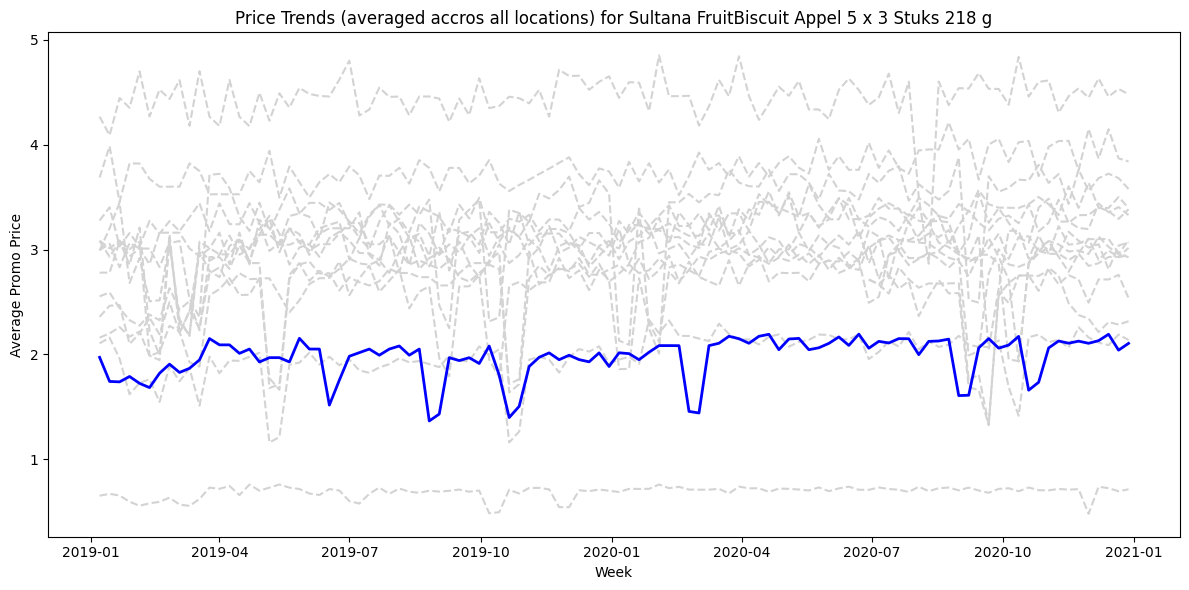

In [42]:
# Calculate average promo prices across all locations for all products
average_prices_alternatives = weekly_prices_brand_alternatives.groupby(['week', 'name'])['price_promo'].mean().reset_index()

# Calculate average promo prices across all locations for the specified product
average_prices_product = weekly_prices_brand[weekly_prices_brand['name'] == product].groupby('week')['price_promo'].mean().reset_index()

# Plot average prices for all products from weekly_prices_brand_alternatives
plt.figure(figsize=(12, 6))
plt.title(f"Price Trends (averaged accros all locations) for {product}")
plt.xlabel('Week')
plt.ylabel('Average Promo Price')

# Plot data for each product from weekly_prices_brand_alternatives
for name in average_prices_alternatives['name'].unique():
    product_data = average_prices_alternatives[average_prices_alternatives['name'] == name]
    sns.lineplot(x='week', y='price_promo', data=product_data, label=f"{name} - Promo Price", color='lightgrey', linestyle='--')

# Plot average prices for the specified product from weekly_prices_brand
sns.lineplot(x='week', y='price_promo', data=average_prices_product, label=f"{product} - Average Promo Price", color='blue', linestyle='-', linewidth=2)

# Show legend and adjust layout
# plt.legend(title='Product')
plt.legend().remove()
plt.xticks()
plt.tight_layout()
plt.show()



In [61]:
# Get unique product names
unique_shops = weekly_prices_brand['shop'].unique()

# Print unique product names for verification
print(f"The products of {brand} are sold in:")
for shop in unique_shops:
    print(shop)

print("\n")

# Get unique product names
unique_locations = weekly_prices_brand['location'].unique()

# Print unique product names for verification
print(f"The products of {brand} are sold in:")
for location in unique_locations:
    print(location)

The products of sultana are sold in:
lld
frc


The products of sultana are sold in:
base
boondael-elsene-brussel
drogenbos
mont-st-jean
waterloo-centrum
froissart
sint-agatha-berchem
gerpinnes
wilrijk
wemmel


In [62]:
# Get unique product names
unique_shops = weekly_prices_brand_alternatives['shop'].unique()

# Print unique product names for verification
print(f"The products of the altnerative brands are sold in:")
for shop in unique_shops:
    print(shop)

print("\n")

# Get unique product names
unique_locations = weekly_prices_brand_alternatives['location'].unique()

# Print unique product names for verification
print(f"The products of the the altnerative brands are sold in:")
for location in unique_locations:
    print(location)

The products of the altnerative brands are sold in:
frc


The products of the the altnerative brands are sold in:
base
boondael-elsene-brussel
drogenbos
mont-st-jean
waterloo-centrum
froissart
sint-agatha-berchem
gerpinnes
wilrijk
wemmel
